# Toy Distributions for L2HMC

## Setup

### Imports

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Global imports
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import horovod.tensorflow as hvd
hvd.init()

from collections import namedtuple

# append parent directory to `sys.path`
# to load from modules in `../l2hmc-qcd/`
module_path = os.path.join('..')
if module_path not in sys.path:
    sys.path.append(module_path)

# Local imports
from utils.attr_dict import AttrDict
from utils.training_utils import setup_directories, train_dynamics
from dynamics.base_dynamics import BaseDynamics
from dynamics.generic_dynamics import GenericDynamics
from network.generic_network import GenericNetwork
from config import (State, NetWeights, MonteCarloStates,
                    DynamicsConfig, NetworkConfig, lrConfig,
                    BASE_DIR, BIN_DIR, TF_FLOAT)

from utils.distributions import (plot_samples2D, contour_potential,
                                 two_moons_potential, sin_potential,
                                 sin_potential1, sin_potential2)

sns.set_palette('bright')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Plot examples of (toy) target distributions:

<IPython.core.display.Javascript object>


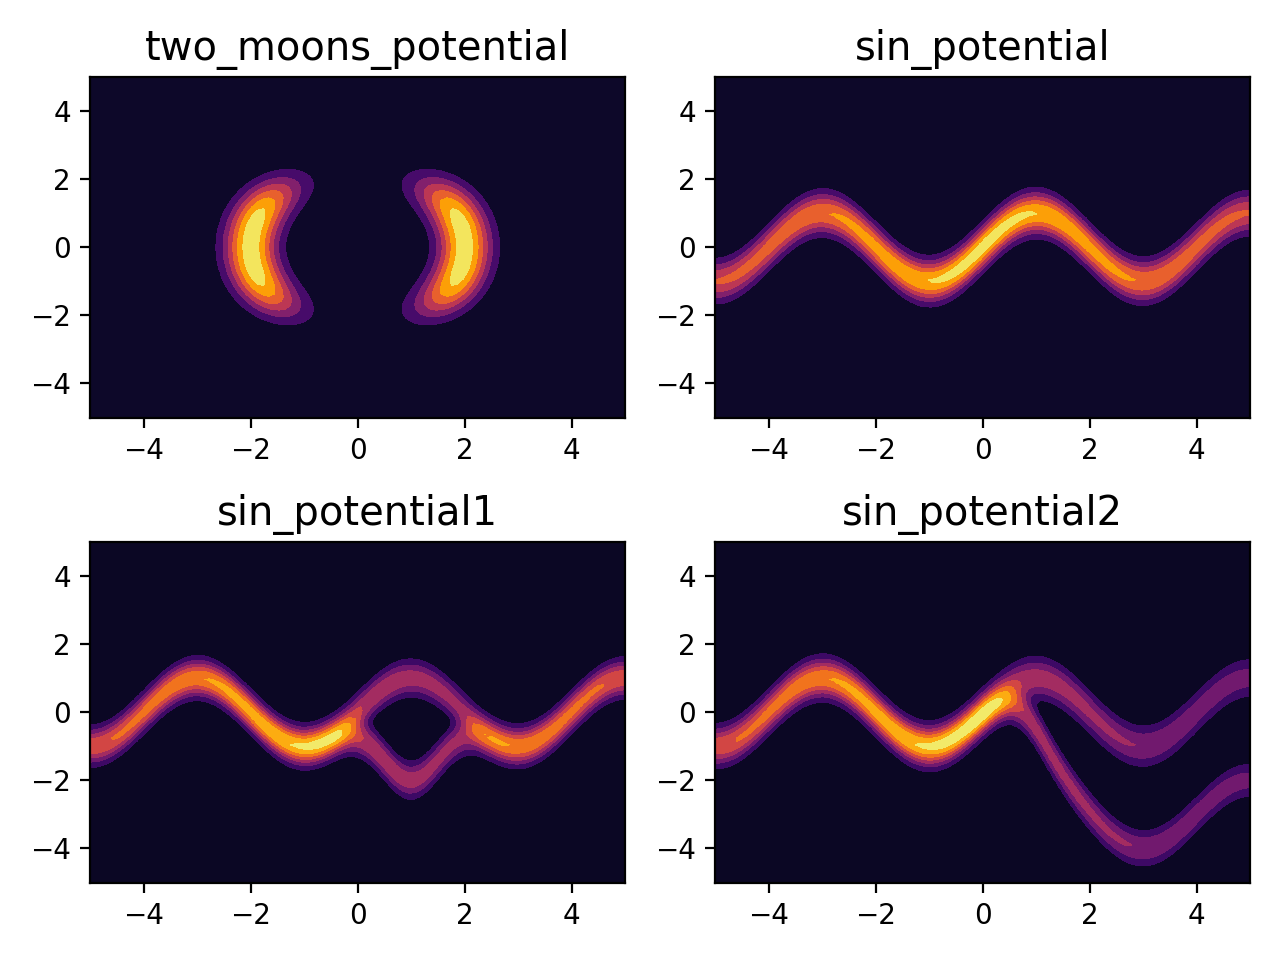

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes = axes.flatten()
names = ['two_moons_potential', 'sin_potential', 'sin_potential1', 'sin_potential2']
potentials = [two_moons_potential, sin_potential, sin_potential1, sin_potential2]
potentials_and_axes = zip(potentials, axes)
for idx, (p_fn, ax) in enumerate(zip(potentials, axes)):
    _ = contour_potential(p_fn, ax, title=f'{names[idx]}')
plt.show()

## Define parameters of the model and target distribution:

In [5]:
import datetime

# DEFINE THE TARGET DISTRIBUTION
MODEL_TYPE='two_moons_potential'
POTENTIAL_FN = two_moons_potential

now = datetime.datetime.now()
date_str = now.strftime('%Y-%m-%d')
timestamp = now.strftime('%Y-%m-%d-%H%M%S')
log_dir = os.path.join(BASE_DIR, MODEL_TYPE, date_str)
if os.path.isdir(log_dir):
    log_dir = os.path.join(log_dir, timestamp)


flags = AttrDict({
    'restore': False,
    'horovod': False,
    'profiler': False,
    'xdim': 2,
    'eps': 0.2,
    'batch_size': 256,
    'num_steps': 10,
    'beta_init': 0.5,
    'beta_final': 1.,
    'compile': True,
    'hmc_steps': 1000,
    'lr_init': 1e-3,
    'train_steps': 10000,
    'clip_value': 0.,
    'decay_rate': 0.96,
    'save_steps': 1000,
    'logging_steps': 250,
    'warmup_steps': 500,
    'print_steps': 100,
    'units': [100, 100],
    'hmc': False,
    'eps_trainable': True,
    'model_type': MODEL_TYPE,
    'network_name': 'GenericNetwork',
    'dropout_prob': 0.25,
    'activation_fn': tf.nn.relu,
    'log_dir': log_dir,
})

flags.decay_steps = flags.train_steps // 5
#flags.warmup_steps = flags.train_steps // 10

## Train:

### Start by training HMC to find optimal step-size $\varepsilon$ and thermalized config $x_{\mathrm{therm}}$ 

In [6]:
x_shape = (flags.batch_size, flags.xdim)
x = tf.random.normal(shape=x_shape, dtype=TF_FLOAT)

net_config = NetworkConfig(units=flags.units,
                           dropout_prob=flags.dropout_prob,
                           name=flags.network_name,
                           activation_fn=flags.activation_fn)

lr_config = lrConfig(flags.lr_init,
                     decay_steps=flags.decay_steps,
                     decay_rate=flags.decay_rate,
                     warmup_steps=flags.warmup_steps)

# TRAIN HMC
if flags.hmc_steps > 0:
    hmc_flags = AttrDict(dict(flags))
    #hmc_flags.train_steps = hmc_flags.pop('hmc_steps')
    hmc_flags.train_steps = 1000
    hmc_flags.logging_steps = hmc_flags.train_steps // 20
    hmc_flags.beta_final = hmc_flags.beta_init
    hmc_flags.compile = True
    hmc_config = DynamicsConfig(eps=hmc_flags.eps,
                                num_steps=hmc_flags.num_steps,
                                hmc=True,
                                eps_trainable=flags.eps_trainable,
                                model_type=MODEL_TYPE)
    hmc_dynamics = GenericDynamics(params=hmc_flags,
                                   config=hmc_config,
                                   lr_config=lr_config,
                                   network_config=net_config,
                                   potential_fn=POTENTIAL_FN,
                                   name=MODEL_TYPE)
    hmc_dirs = setup_directories(hmc_flags, 'training_hmc')
    x, train_data = train_dynamics(hmc_dynamics, hmc_flags, dirs=hmc_dirs, x=x)
    
    output_dir = os.path.join(hmc_dirs.train_dir, 'outputs')
    train_data.save_data(output_dir)
    flags.eps = hmc_dynamics.eps.numpy()

2020-08-29 02:20:14,603:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29
2020-08-29 02:20:14,605:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29/training_hmc
2020-08-29 02:20:14,606:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29/training_hmc/train_data
2020-08-29 02:20:14,608:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29/training_hmc/checkpoints
2020-08-29 02:20:14,610:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29/training_hmc/summaries
2020-08-29 02:20:14,612:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29/training_hmc/dynamics_configs
2020-08-29 02:20:14,615:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29/training_hmc/FLAGS.z.
2020-08-29 02:20:14,634:INFO:************************************************************************************************

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
     0/1000    0.02541      -6.094      0.9894       0.2         0.5          0      
   100/1000    0.02049      -1.97       0.9873      0.1994       0.5          0      
   200/1000    0.01836      -1.832      0.9914      0.1987       0.5          0      
   300/1000    0.01809      -2.665      0.9873      0.1948       0.5          0      
   400/1000    0.01825      -2.273      0.9825      0.2085       0.5          0      
   500/1000    0.01736      -3.005      0.9854      0.2033       0.5          0      
   600/1000    0.01843      -1.45       0.9889      0.1881       0.5          0      
   700/1000    0.01771      -2.557      0.9943      0.1799       0.5          0      
   800/1000    0.01699     -0.1792      0.9918      0.182

### Create `GenericDynamics` object

In [7]:
def identity(x):
    return x

config = DynamicsConfig(eps=flags.eps,
                        num_steps=flags.num_steps,
                        hmc=flags.hmc,
                        eps_trainable=flags.eps_trainable,
                        model_type=flags.model_type)
                        

net_config = NetworkConfig(units=flags.units,
                           dropout_prob=flags.dropout_prob,
                           name=flags.network_name,
                           activation_fn=flags.activation_fn)

lr_config = lrConfig(flags.lr_init,
                     decay_steps=flags.decay_steps,
                     decay_rate=flags.decay_rate,
                     warmup_steps=flags.warmup_steps)

dynamics = GenericDynamics(params=flags,
                           config=config,
                           lr_config=lr_config,
                           normalizer=identity,
                           network_config=net_config,
                           potential_fn=POTENTIAL_FN,
                           name=MODEL_TYPE)

### Train L2HMC sampler using HMC sampler as starting point

In [8]:
dirs = setup_directories(flags)
x, train_data = train_dynamics(dynamics, flags, dirs=dirs, x=x)

2020-08-29 02:21:04,692:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29/training
2020-08-29 02:21:04,693:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29/training/train_data
2020-08-29 02:21:04,694:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29/training/checkpoints
2020-08-29 02:21:04,695:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29/training/summaries
2020-08-29 02:21:04,695:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29/training/dynamics_configs
2020-08-29 02:21:04,696:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29/training/FLAGS.z.
2020-08-29 02:21:05,760:INFO:************************************************************************************************************************
2020-08-29 02:21:19,098:INFO:Compiled `dynamics.train_step` using tf.function!
2020-08-29 02:21:19,098:IN

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
     0/10000   0.04512      0.9121      0.913       0.1938       0.5      -0.002457  
   100/10000   0.03624      -1.014      0.9151      0.1946      0.5035     0.005464  
   200/10000   0.04433      -1.558      0.8544      0.1943      0.507      0.005606  
   300/10000   0.05285     -0.5351      0.8316      0.199       0.5105    -0.006193  
   400/10000   0.06135      1.203       0.6693      0.1998      0.5141     -0.01278  
   500/10000   0.06276      -1.373      0.7276      0.197       0.5176     0.001287  
   600/10000   0.07315      9.078       0.4006      0.197       0.5212     0.00541   
   700/10000   0.06287      3.928       0.3958      0.199       0.5249    -0.007203  
   800/10000   0.08155      26.68       0.4998      0.202

  9000/10000   0.06266      2.239       0.595      0.03118      0.9331    -0.001571  
  9100/10000   0.06037      3.282       0.6281     0.03012      0.9396     0.001105  
  9200/10000   0.06301      6.881       0.6263     0.02794      0.9461    -0.001563  
  9300/10000   0.05176      3.369       0.619      0.02609      0.9527     0.000712  
  9400/10000   0.05208      2.911       0.6159     0.02636      0.9593    -0.001556  
  9500/10000   0.05252      2.538       0.6229     0.02891      0.966     -0.001351  
  9600/10000   0.05208      2.396       0.6486     0.02625      0.9727     0.002092  
  9700/10000   0.05055      3.552       0.6225     0.02506      0.9795     0.000127  
  9800/10000   0.06543      2.261       0.6405     0.02619      0.9863    -0.0006708 
  9900/10000   0.06102      1.902       0.6934     0.02422      0.9932    -0.0001721 
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps

## Run inference:

In [9]:
import utils.file_io as io

dirs = setup_directories(flags)

ckpt = tf.train.Checkpoint(model=dynamics, optimizer=dynamics.optimizer)
manager = tf.train.CheckpointManager(ckpt, dirs.ckpt_dir, max_to_keep=5)
if manager.latest_checkpoint:
    io.log(f'INFO:Checkpoint restored from: {manager.latest_checkpoint}')
    ckpt.restore(manager.latest_checkpoint)
    current_step = dynamics.optimizer.iterations.numpy()

2020-08-29 02:56:38,614:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29/training/FLAGS.z.
2020-08-29 02:56:38,618:INFO:INFO:Checkpoint restored from: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29/training/checkpoints/ckpt-11


In [10]:
from utils.inference_utils import run_dynamics
import utils.file_io as io

flags.log_dir = dirs.log_dir
flags.beta = flags.beta_final
flags.run_steps = 2000

summary_dir = os.path.join(flags.log_dir, 'inference', 'summaries')
io.check_else_make_dir(summary_dir)
writer = tf.summary.create_file_writer(summary_dir)
writer.set_as_default()

flags.run_steps = 5000
run_data, x, x_arr = run_dynamics(dynamics, flags, save_x=True)

writer.flush()
writer.close()

2020-08-29 02:56:53,817:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29/inference/summaries
2020-08-29 02:56:53,819:INFO:Running inference with:
 beta: 1.0
eps: 0.02276
net_weights: NetWeights(x_scale=1.0, x_translation=1.0, x_transformation=1.0, v_scale=1.0, v_translation=1.0, v_transformation=1.0)
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


     0/5000    0.01069      5.224       0.638      0.02276        1        0.003852  
   100/5000    0.006695     3.765       0.7042     0.02276        1        0.001182  
   200/5000    0.007653     2.218       0.7079     0.02276        1        0.001615  
   300/5000    0.006988     2.525       0.6722     0.02276        1       -0.0002135 
   400/5000    0.006994     3.129       0.6897     0.02276        1       0.0008134  
   500/5000    0.006949     2.114       0.715      0.02276        1       -0.005134  
   600/5000    0.006498     2.332       0.714      0.02276        1       -0.003102  
   700/5000    0.00693      2.996       0.6856     0.02276        1       0.0007585  
   800/5000    0.007179     2.681       0.6957     0.02276        1        0.001464  
   900/5000    0.007337     3.132       0.6811     0.02276        1       -0.003832  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps

2020-08-29 02:59:00,920:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29/figures
Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29/figures/trained_samples_chain0.png


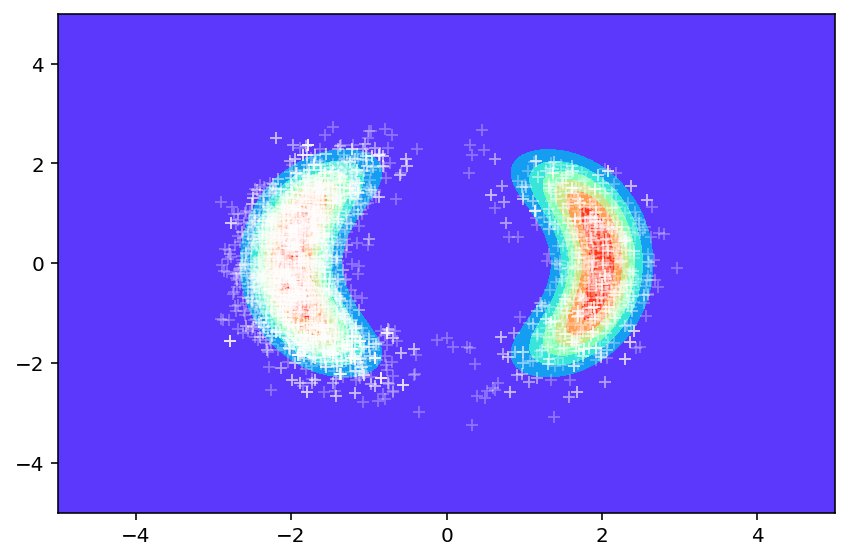

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29/figures/trained_samples_chain1.png


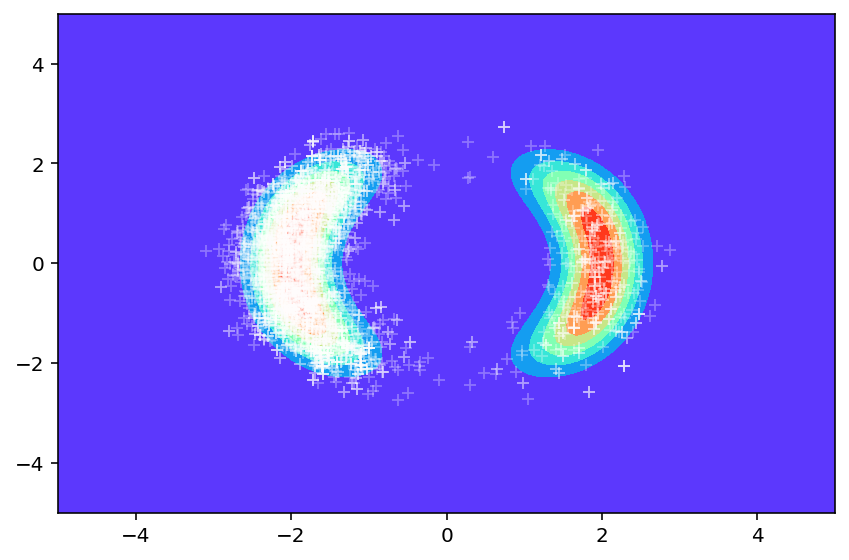

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29/figures/trained_samples_chain2.png


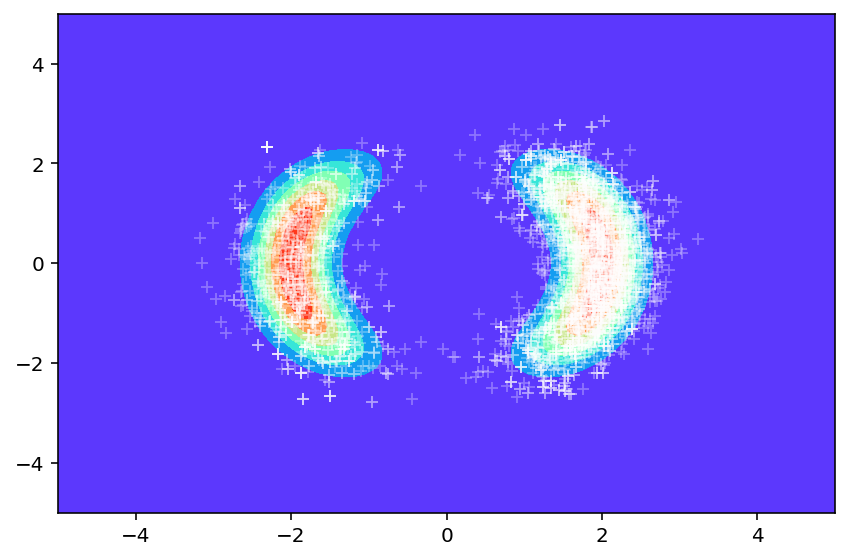

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons_potential/2020-08-29/figures/trained_samples_chain3.png


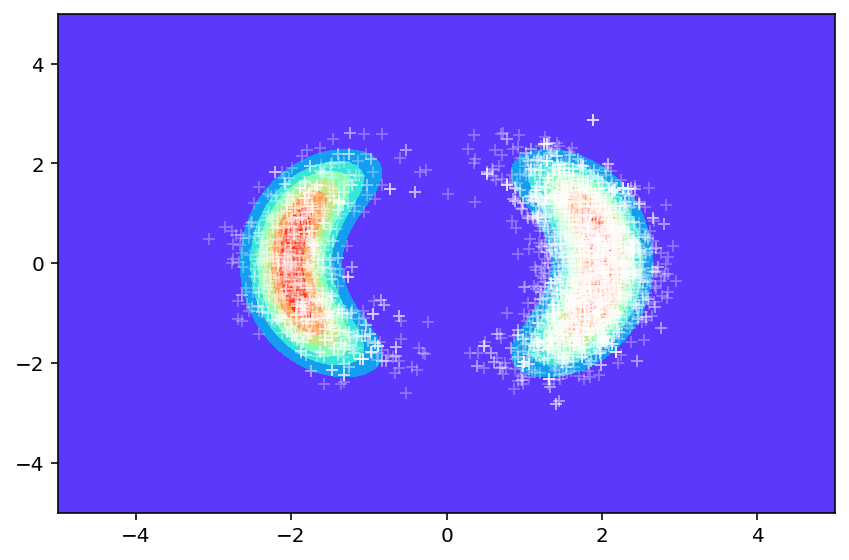

In [11]:
import utils.file_io as io
from utils.distributions import contour_potential

%matplotlib inline

figs_dir = os.path.join(dirs.log_dir, 'figures')
io.check_else_make_dir(figs_dir)

x_arr = tf.convert_to_tensor(x_arr).numpy()

for chain in range(4):
    fig, ax = plt.subplots()
    xy = np.array((x_arr[1000:, chain, 0], x_arr[1000:, chain, 1]))
    #sns.kdeplot(*xy, ax=ax)
    #grid = xy.reshape(2, -1).T
    #Z = np.exp(-POTENTIAL_FN(grid))
    #_ = ax.contourf(xy[0], xy[1], Z.reshape(xy[0].shape, xy[1].shape), cmap='inferno')
    #xlim = np.abs(np.floor(np.min(xy[0]))) + 1
    #ylim = np.abs(np.floor(np.max(xy[1]))) + 1
    xlim = 5
    ylim = 5
    _ = contour_potential(POTENTIAL_FN, ax=ax, cmap='rainbow', xlim=xlim, ylim=ylim)
    _ = ax.plot(*xy, alpha=0.3, mew=0.9, ls='', marker='+',
                color='white', label='l2hmc samples')
    #_ = ax.legend(markerscale=5., loc='best')
    _ = ax.set_xlim((-xlim, xlim))
    _ = ax.set_ylim((-ylim, ylim))
    out_file = os.path.join(figs_dir, f'trained_samples_chain{chain}.png')
    print(f'Saving figure to: {out_file}')
    _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')
    plt.show()